『統計的テキストモデル』持橋大地著, 岩波書店 (2025)
## 4章 文の統計モデル

In [1]:
# ライブラリと環境の準備
import os
import sys
!pip install japanize_matplotlib
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=195cc2244caae2fb56896f052361762784a3cb29a8dbd710dfbab1478b886578
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize_matplotlib


In [3]:
sys.path.append (os.getcwd() + '/bin')
%env PATH={os.getcwd()+'/bin'}:{os.environ['PATH']}
%matplotlib inline

env: PATH=/content/bin:/content/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


In [15]:
# スクリプトとデータの準備
!curl -O http://chasen.org/~daiti-m/textmodel/sent/sent.tar.gz
!tar xvfz sent.tar.gz
![ ! -d stat ] && mkdir stat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  489M  100  489M    0     0  11.0M      0  0:00:44  0:00:44 --:--:-- 10.4M
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
sent.ipynb
bin/
bin/igp_plot.py
bin/bhmm.py
bin/gauss1.py
bin/mixture-gibbs.py
bin/unigram.py
bin/slice.py
bin/igp.py
bin/similars.py
bin/util.py
bin/gauss-gibbs.py
bin/rutil.py
bin/length.py
bin/hmmgen.py
bin/sif.py
bin/perplexity.py
bin/usif.py
bin/ustring.py
bin/gauss-contour.py
bin/putil.py
bin/eprint.py
bin/stsplot.py
bin/pysbd
bin/viterbi0.py
bin/opts.py
bin/sif-word2vec-weights.py
bin/ststask.py
bin/showparse.py
bin/sif-weights.py
bin/trans.py
bin/loggings.py
bin/readword.py
bin/parse.py
bin/shmm.py
bin/states.py
bin/emit.py
bin/hinton.py
bin/strip.sed
bin/viterbi.py
bin/emission.py
bin/klingon.py
bin/pklread
bin/hmm.py
data/
data/klingon.dic
data/klingon.lex
da

## 4.1 テキストの文分割

In [ ]:
!pip install pysbd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import pysbd
text = 'これは日本語のテキスト。文分割！ができるかな?'
seg = pysbd.Segmenter (language='ja', clean=False)
for sent in seg.segment(text):
    print (sent)

これは日本語のテキスト。
文分割！
ができるかな?


In [ ]:
!cat data/input.txt

綺麗になりました。真っ白に戻っていい匂いがします。ヨカッタ。
ゆーちゃん本当に寂しそうやった～あー彩奈も明後日か…


In [ ]:
!bin/pysbd data/input.txt

綺麗になりました。
真っ白に戻っていい匂いがします。
ヨカッタ。

ゆーちゃん本当に寂しそうやった～あー彩奈も明後日か…



## 4.2 文ベクトルと意味的ランダムウォーク

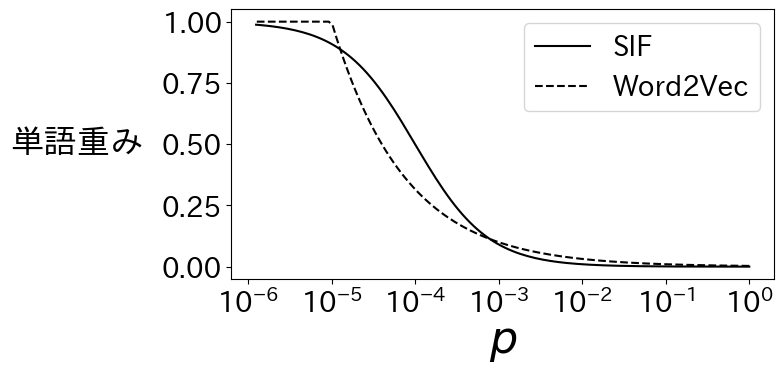

<Figure size 640x480 with 0 Axes>

In [ ]:
# 単語の確率pとSIFによる単語重み (およびWord2Vecのヒューリスティックとの比較)
%run bin/sif-word2vec-weights.py 1e-4 1e-5

In [ ]:
import numpy as np
def sif (p,a):
    return a / (p + a)
def embed (sent, wordvec, wordp, a=1e-4):
    vectors = []
    for word in sent:
        if (word in wordvec) and (word in wordp):
            p = wordp[word]
            vec = wordvec[word]
            vectors.append (sif(p,a) * vec)
    return np.mean (vectors, axis=0)

In [ ]:
# 単語のユニグラム確率を計算して、ファイル *.p に保存しておく
!unigram.py data/ja.text8 model/ja.text8.p

reading from "data/ja.text8" 16906155 words.. done.


In [ ]:
# 保存したWord2Vecフォーマットのベクトルを読む関数 (3章)
def loadvec (file):
    vectors = {}
    with open (file, 'r') as fh:
        for line in fh:
            tokens = line.rstrip('\n').split()
            if len(tokens) > 2: # Word2Vecのヘッダをスキップ
                word = tokens[0]
                vector = np.array (list (map (float, tokens[1:])))
                vectors[word] = vector / norm(vector)
    return vectors
def norm (x):
    return np.sqrt (np.dot (x,x))

In [ ]:
def loadp (file):
    p = {}
    with open (file, 'r') as fh:
        for line in fh:
            tokens = line.rstrip('\n').split('\t')
            if not (len(tokens) == 2):
                print ('error! invalid line.')
                sys.exit (1)
            else:
                word = tokens[0]
                prob = float (tokens[1])
                p[word] = prob
    print ('done.')
    return p

In [ ]:
wordvec = loadvec("model/ja.text8.vec")

In [ ]:
wordp = loadp("model/ja.text8.p")

done.


In [ ]:
wordvec["真夜中"]

array([-0.074971  , -0.01916125, -0.04451807,  0.05477093,  0.05148379,
       -0.01573418, -0.02525607,  0.02070437, -0.0306823 , -0.01939974,
       -0.09512045, -0.23281271,  0.02281454,  0.15445757,  0.10991692,
       -0.05266357, -0.02904918,  0.02479796,  0.0051639 , -0.2152674 ,
       -0.03746552,  0.08505332, -0.12280996, -0.1738252 ,  0.10248898,
        0.14543362,  0.01149011,  0.13105438,  0.01080788, -0.09881333,
        0.01898483,  0.01667435,  0.03381593, -0.02187108,  0.14235104,
        0.05372637,  0.06903478,  0.0342424 , -0.17872017,  0.00462581,
        0.00397108,  0.1724103 ,  0.05438288,  0.00742464, -0.1379465 ,
       -0.05602366, -0.19082765, -0.04433351, -0.0264776 ,  0.03388728,
        0.08188618,  0.06721172,  0.03506084,  0.02394818, -0.00892047,
        0.09284239,  0.04008461,  0.05255918, -0.08610825,  0.10828302,
        0.03568478,  0.15029726,  0.15250359,  0.10133819, -0.03238749,
       -0.01080089, -0.07106646,  0.07459417, -0.11223293,  0.20

In [ ]:
wordvec["の"]

array([-0.07364649, -0.08880768,  0.04345017, -0.13372037, -0.07953416,
        0.06462863, -0.08844142, -0.1465094 ,  0.07755174, -0.04427627,
        0.18765291, -0.11705118,  0.25736994,  0.00539721, -0.01115022,
        0.00722895,  0.09288979,  0.08931451, -0.13833037, -0.03314963,
        0.04625522,  0.00161223, -0.10730956,  0.11708468, -0.03240765,
        0.07600539,  0.12805383, -0.00279711, -0.04760571,  0.06705092,
        0.07174701, -0.12997866,  0.10479921,  0.17989733, -0.14059931,
        0.04513271,  0.04141311,  0.1609523 ,  0.08465103, -0.18018831,
       -0.09522396,  0.08276749, -0.1673502 , -0.00100978, -0.14178252,
        0.0090647 , -0.14055418,  0.1091804 , -0.13973641, -0.02147302,
       -0.03543493,  0.13633979,  0.00386414,  0.07141846,  0.06268887,
       -0.04293287, -0.14478365, -0.11390857, -0.14273038, -0.200069  ,
       -0.00495872, -0.0931165 , -0.0800905 , -0.06470775,  0.09006095,
        0.04048125,  0.00363926,  0.08416035,  0.09648421, -0.18

In [ ]:
# SIF文ベクトルの計算
# 参考: 岩波書店 https://www.iwanami.co.jp/book/b269516.html
s = ["トム", "は", "真夜中", "の", "庭", "で"]
embed (s, wordvec, wordp, 1e-4)

array([-0.04476651, -0.01037239, -0.0230103 ,  0.00566982,  0.00927914,
       -0.01481874, -0.03203674,  0.04265289,  0.00391881, -0.0137929 ,
       -0.01153813, -0.05831154,  0.00531137,  0.02965867,  0.02698751,
       -0.02541742,  0.00911771,  0.01825307, -0.01601558, -0.03619026,
        0.00472891,  0.03478813, -0.03984864, -0.03629862,  0.05509914,
        0.04170763,  0.01888915,  0.06807213, -0.00186162,  0.03520577,
        0.00436763,  0.01599551,  0.00853853,  0.00349916,  0.02677254,
        0.01428851,  0.0227822 ,  0.04186154, -0.02876626,  0.00243685,
        0.00179569,  0.03498306,  0.01820902, -0.02107346, -0.03931811,
        0.01829352, -0.06442687, -0.01693732, -0.00662255,  0.02191598,
        0.04099027,  0.00254708,  0.02058565, -0.01761406, -0.00764631,
        0.00403791, -0.00798521,  0.00731378, -0.03651171,  0.0104123 ,
       -0.00516289,  0.03927031,  0.06813298,  0.01756031, -0.02894672,
        0.00392047, -0.01146193,  0.01395098, -0.04504955,  0.04

In [ ]:
# uSIF文ベクトルの計算
!echo "トム は 真夜中 の 庭 で" > data/sent.txt
!usif.py model/ja.text8.vec model/ja.text8.p data/sent.txt

loading from "model/ja.text8.vec".. done.
loading word probabilities from "model/ja.text8.p".. done.
[-0.09597217 -0.02165531 -0.04875594  0.01077781  0.01854205 -0.03169501
 -0.06930885  0.09186846  0.00900854 -0.02908734 -0.02271806 -0.1208912
  0.01147813  0.06023424  0.05580838 -0.053637    0.02061621  0.03910876
 -0.03534184 -0.07359938  0.0114017   0.07400408 -0.08335197 -0.07400618
  0.11766607  0.08741974  0.04121746  0.14448331 -0.00411107  0.07972035
  0.0089775   0.03383801  0.01769116  0.00899898  0.05466453  0.0299823
  0.04762971  0.09079489 -0.05732169  0.00473616  0.00332455  0.07192713
  0.03777269 -0.04624066 -0.08200476  0.04113171 -0.13526695 -0.03553126
 -0.01405297  0.046564    0.08742652  0.00380479  0.04404346 -0.03911826
 -0.01626004  0.0058674  -0.01882961  0.01434108 -0.07783272  0.01956978
 -0.0117623   0.08126896  0.14428419  0.03551334 -0.06251371  0.00921543
 -0.02282393  0.02861488 -0.09463837  0.09342141  0.0223706   0.15880586
 -0.05509373 -0.10536041 

In [ ]:
!usif.py model/ja.text8.vec model/ja.text8.p data/sentences-jp.txt stat/sentences-jp.vec

loading from "model/ja.text8.vec".. done.
loading word probabilities from "model/ja.text8.p".. done.
writing to stat/sentences-jp.vec..
done.


In [ ]:
!similars.py data/sentences-jp.txt stat/sentences-jp.vec 1

 1.0000	だが、新しい後期高齢者医療制度では、介護..
 0.8840	健康保険や介護保険、厚生年金、雇用保険、..
 0.8702	国は患者が混合診療を受けた場合、「一体化..
 0.8591	労働保険は、法人個人を問わず労働者を1人で..
 0.8319	また、短期入所や通所を受け入れる福祉施設..
 0.8224	この免除の手続きをするだけで、保険料を払..
 0.8207	全体で５％アップと同水準だが、保険制度の..
 0.8171	また、介護保険は対象外となっています。
 0.8159	「住宅ローン控除」は、国内で一定の居住用..
 0.8156	「年金制度は世代間扶養の仕組みである」→「..
 0.8065	実は、総務省が07年4月に、バス運転手の給与..
 0.8036	連合はほかに「中低所得者層の所得税減税」..
 0.8005	語学学校は特定商取引法の指定業務で、受講..
 0.7951	機構や文部科学省によると、新制度は、悪質..
 0.7877	一方、原則３割の医療費の自己負担を、３歳..
 0.7765	自民は職員人件費の削減幅が一般職の基本給..
 0.7760	他に相続人がいない場合に、特別縁故者の手..
 0.7703	主に機関投資家が取引する通常の国債と異な..
 0.7692	判決はまず、旧厚生省令で明確な禁止規定が..
 0.7683	厚生労働省は２６日、サービス事業者に支払..


In [ ]:
!similars.py data/sentences-jp.txt stat/sentences-jp.vec 1000 20

 1.0000	再生可能なファイル形式は、映像がMPEG-1/2..
 0.8957	無線LANセキュリティは64/128bitのWEP、WPA..
 0.8857	ネットワーク機能は10/100/1000BASE-T対応有..
 0.8805	録音形式はリニアPCMで16bit/44.1kHzおよび..
 0.8602	基本仕様はMP3/WMA/AAC再生。
 0.8574	その他の機能は地上デジタル/BSデジタル/11..
 0.8553	その他の機能は、IEEE802.11b/g/n対応無線L..
 0.8492	入出力端子にはHDMI/コンポジットビデオ、L..
 0.8469	その他の機能は、10BASE-T/100BASE-TX対応有..
 0.8445	対応OSは、WindowsXP(SP2/SP3)/Vista(SP1)、..
 0.8366	対応ゲストOSはOracleEnterpriseLinux4/5、..
 0.8319	Blu-rayディスク作成においては、1080i/720..
 0.8308	動作環境はWindows95/98/ME、WindowsNT/200..
 0.8280	同サービスは、iモード/EZweb/Yahoo!ケータ..
 0.8263	CG-BARPROG-Xコレガは、WAN/LANがギガビット..
 0.8247	無線帯域は2.4GHz帯802.11b/gと5GHz帯.11aの..
 0.8237	いずれもファイル形式はWindowsMediaVideoで..
 0.8072	「morawin[モーラウィン]forS!ミュージック..
 0.8064	有償プランは、HDD容量が2GB/IDの「Giga2」..
 0.8050	Mac版では、MacOSXTiger(v10.4)のフルサポー..


In [ ]:
# STS (意味的文類似度) タスクによるベンチマーク
# text9からWord2Vecで計算した200次元の単語ベクトルを使ってみる
!ststask.py data/sts/sts-test.txt model/text9.vec model/text9.p > stat/scores.text9

loading from "model/text9.vec".. done.
loading word probabilities from "model/text9.p".. done.


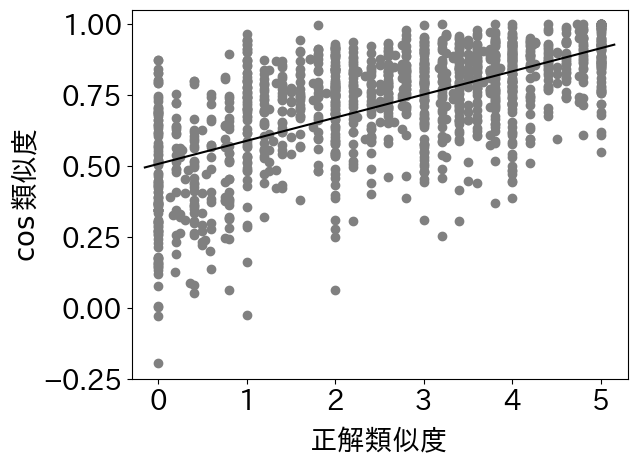

<Figure size 640x480 with 0 Axes>

In [ ]:
%run bin/stsplot.py stat/scores.text9

In [ ]:
# 同じベクトルを白色化したもので同様に類似度を計算する
!ststask.py data/sts/sts-test.txt model/text9.white.vec model/text9.p > stat/scores.text9.white

loading from "model/text9.white.vec".. done.
loading word probabilities from "model/text9.p".. done.


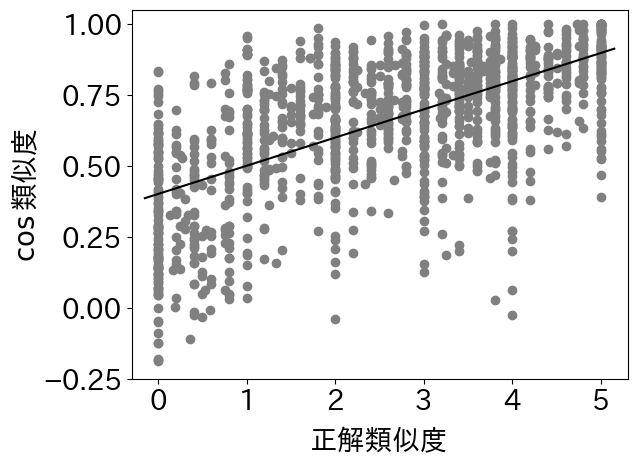

<Figure size 640x480 with 0 Axes>

In [ ]:
# やや相関係数が高くなっている
%run bin/stsplot.py stat/scores.text9.white

## ノート: 文の長さの統計モデル

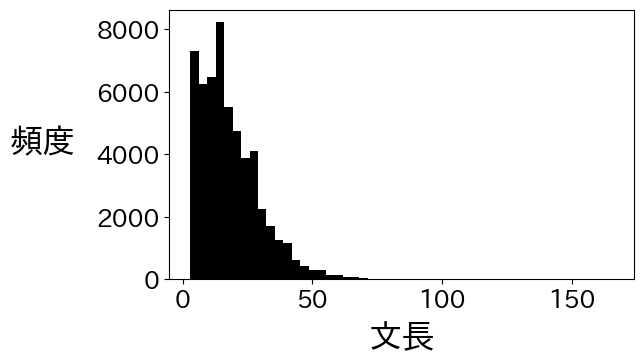

<Figure size 640x480 with 0 Axes>

In [ ]:
%run bin/length.py -w data/brown.txt

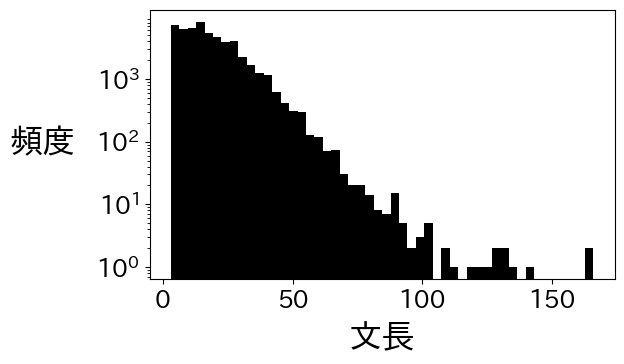

<Figure size 640x480 with 0 Axes>

In [ ]:
%run bin/length.py -w -l data/brown.txt

## 4.3 構文解析と係り受け解析

In [ ]:
!curl -O 'https://downloads.cs.stanford.edu/nlp/software/stanford-corenlp-4.5.10.zip'

In [ ]:
!pip install spacy
!pip install ja-ginza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 94.9 MB/s eta 0:00:00


In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load('ja_ginza')
sent = nlp('健は奈緒美が話したと思った')
displacy.render (sent, style='dep', options={'compact':True})

## 4.4 隠れマルコフモデル (HMM)

In [ ]:
!pip install mecab-python3
!pip install unidic-lite

In [ ]:
import MeCab
tagger = MeCab.Tagger ()
list (map (lambda x: x.split(),
           tagger.parse('法子はそう言った').split('\n')[:-1]))

[['法子', 'ノリコ', 'ノリコ', 'ノリコ', '名詞-固有名詞-人名-名', '1'],
 ['は', 'ワ', 'ハ', 'は', '助詞-係助詞'],
 ['そう', 'ソー', 'ソウ', 'そう', '副詞', '1'],
 ['言っ', 'イッ', 'イウ', '言う', '動詞-一般', '五段-ワア行', '連用形-促音便', '0'],
 ['た', 'タ', 'タ', 'た', '助動詞', '助動詞-タ', '終止形-一般'],
 ['EOS']]

In [ ]:
# TreeTaggerの使用にはライセンスを読んで同意することが必要なため、教科書のTreeTaggerの実行例を試す
# には、下の配布サイトから別途ダウンロードして実行して下さい。
# https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/

In [ ]:
# 隠れマルコフモデルの生成モデル
from numpy.random import rand
def multinom (p):
    s = 0
    K = len(p)
    r = rand()
    for k in range(K):
        s += p[k]
        if (r < s):
            return k
    print ('multinom: error! s = %f' % s)
    return K-1

In [ ]:
p = [0.2,0.1,0.3,0.4]

In [ ]:
multinom(p)

2

In [ ]:
multinom(p)

0

In [ ]:
# HMMの真の状態とそこからの出力を生成する関数
def gen (trans, emit):
    K = emit.shape[0]
    pz = K
    zz = []
    words = []
    while True:
        z = multinom (trans[pz])
        if (z == K):
            break
        else:
            w = multinom (emit[z])
        zz.append (z+1)
        words.append (w)
        pz = z
    return words, zz

In [ ]:
import numpy as np
trans = np.loadtxt ('data/trans.dat', dtype=float)
emit  = np.loadtxt ('data/emit.dat', dtype=float)

In [ ]:
trans

array([[ 0.200,  0.700,  0.000,  0.100],
       [ 0.500,  0.200,  0.300,  0.000],
       [ 0.100,  0.400,  0.300,  0.200],
       [ 1.000,  0.000,  0.000,  0.000]])

In [ ]:
emit

array([[ 0.400,  0.200,  0.300,  0.100,  0.000],
       [ 0.000,  0.600,  0.100,  0.200,  0.100],
       [ 0.100,  0.000,  0.000,  0.400,  0.500]])

In [ ]:
gen (trans, emit)

([0, 2, 3, 1, 3, 3, 0, 3, 4, 3, 3, 3, 3],
 [1, 1, 2, 2, 3, 2, 1, 2, 3, 2, 2, 3, 3])

In [ ]:
# HMMの真の状態と、そこからの単語列を生成
!hmmgen.py data/trans.dat data/emit.dat data/dict.dat

words  = B A B A A E B B A D A B E D C D E
states = 1 1 2 1 1 2 1 2 3 2 1 2 3 3 2 2 3


In [ ]:
# 同様に実行して、単語列を words.txt に保存しておく
!hmmgen.py data/trans.dat data/emit.dat data/dict.dat data/words.txt

words  = A E B A B E E B A B B E B D D B B
states = 1 2 2 1 2 3 2 2 1 1 2 3 2 3 3 2 1
words written to data/words.txt.


### 4.4.1 HMMの状態推定

In [ ]:
!cat data/words.txt

A E B A B E E B A B B E B D D B B


In [ ]:
!viterbi.py data/words2.txt data/dict.dat data/trans.dat data/emit.dat

[1 2 1 2 1 2 1 2 1 2 3 3 3 3 3 3 2 3 2 3 3 2 2 3]


### 4.4.2 HMMのパラメータ推定

$p(x,y) = \exp(-x^2-y^2+xy+3x-4)/Z$ のプロット

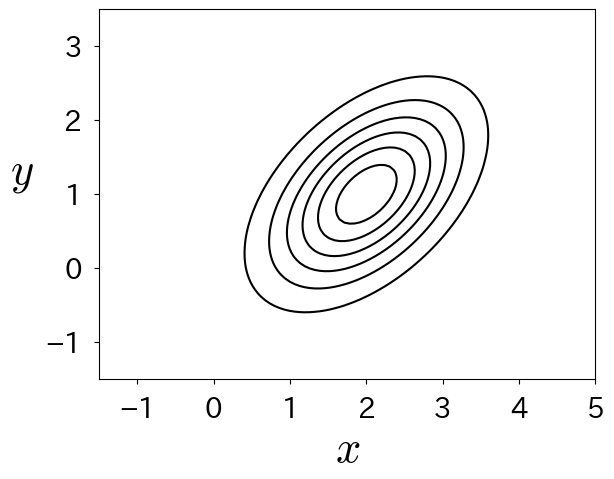

In [ ]:
%run bin/gauss-contour.py

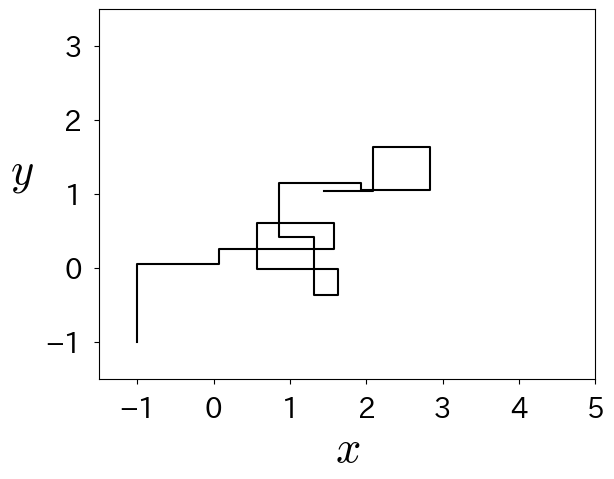

In [ ]:
%run bin/gauss-gibbs.py 10

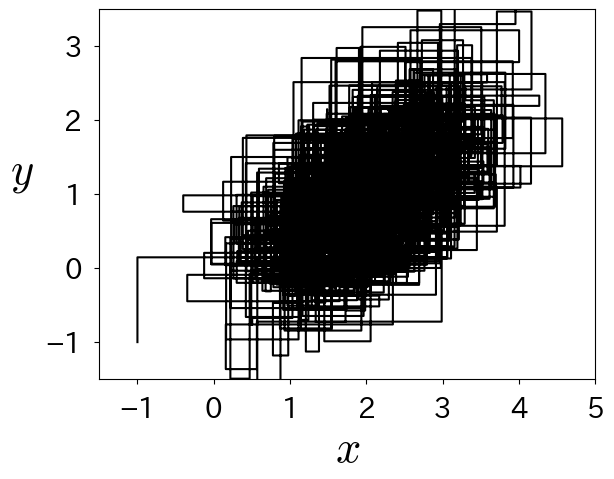

In [ ]:
%run bin/gauss-gibbs.py 1000

/Users/daichi/work/iwanami/www/sent/bin/mixture-gibbs.py:14: RuntimeWarning: divide by zero encountered in log
  y = slice.sample (y, lambda y: log(pdf([x,y])))
/Users/daichi/work/iwanami/www/sent/bin/mixture-gibbs.py:17: RuntimeWarning: divide by zero encountered in log
  x = slice.sample (x, lambda x: log(pdf([x,y])))


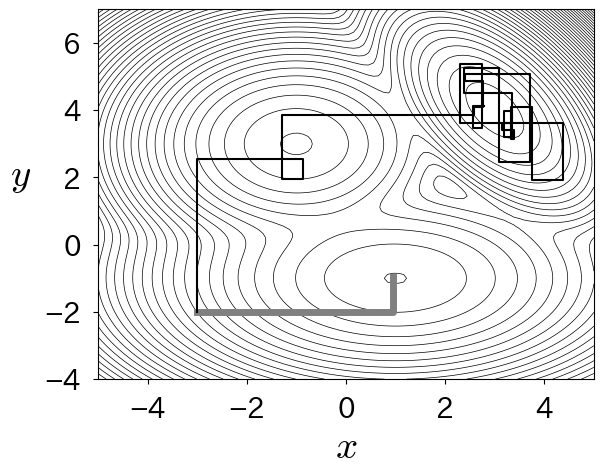

In [ ]:
%run bin/mixture-gibbs.py 20

/Users/daichi/work/iwanami/www/sent/bin/mixture-gibbs.py:14: RuntimeWarning: divide by zero encountered in log
  y = slice.sample (y, lambda y: log(pdf([x,y])))
/Users/daichi/work/iwanami/www/sent/bin/mixture-gibbs.py:17: RuntimeWarning: divide by zero encountered in log
  x = slice.sample (x, lambda x: log(pdf([x,y])))


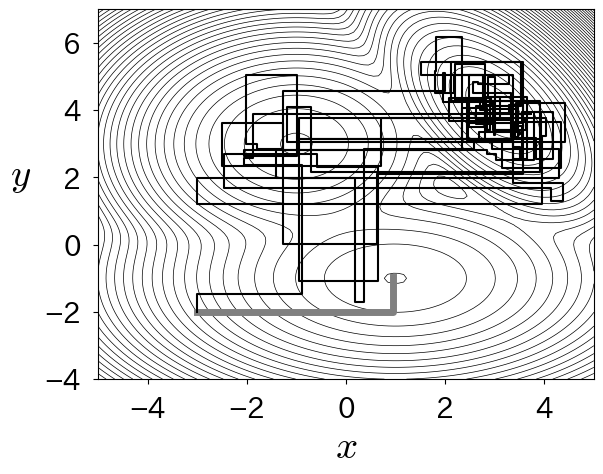

In [ ]:
%run bin/mixture-gibbs.py 100

In [ ]:
!shmm.py -K 10 -N 1000 -t 1 data/alice.txt model/alice.shmm

reading data from data/alice.txt.. done.
data: 1431 sequences, lexicon: 2576 words.
iter[1000]: PPL = 4.55
writing to model/alice.shmm.. done.


In [ ]:
# pickle+gzip圧縮されたモデルファイルの中身を表示する
!pklread model/alice.shmm

zz:
<class 'list'>
trans:
numpy.ndarray of (11, 11)
emit:
numpy.ndarray of (10, 2576)
dic:
dict of length 2576, { 0:_OOV_, 1:the, 2:and, 3:to, 4:a, .. }


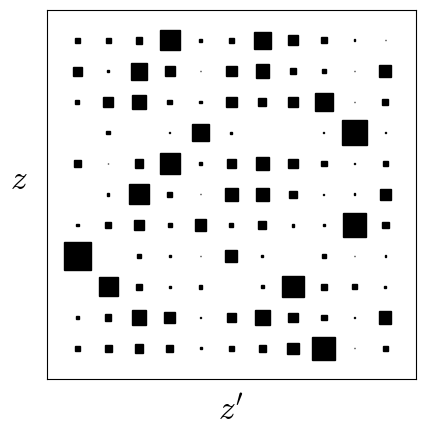

In [ ]:
%run bin/trans.py model/alice.shmm

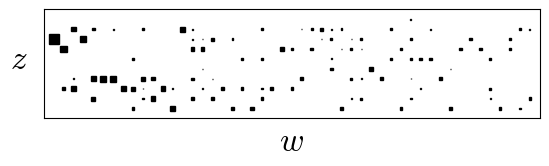

In [ ]:
%run bin/emit.py model/alice.shmm

In [ ]:
!emission.py model/alice.shmm

[state 1]
was        0.1222
had        0.0653
's         0.0590
do         0.0362
would      0.0337
are        0.0323
is         0.0312
could      0.0302
were       0.0284
said       0.0277
did        0.0270

[state 2]
alice      0.1141
it         0.0791
her        0.0384
all        0.0327
them       0.0323
herself    0.0323
that       0.0253
this       0.0206
him        0.0201
see        0.0168
you        0.0145

[state 3]
of         0.1363
to         0.1122
in         0.0979
said       0.0944
at         0.0562
and        0.0560
with       0.0477
on         0.0337
for        0.0300
into       0.0178
about      0.0175

[state 4]
she        0.2017
i          0.1926
it         0.1251
you        0.0999
alice      0.0562
they       0.0543
he         0.0456
there      0.0361
that       0.0252
who        0.0204
what       0.0161

[state 5]
little     0.0916
mock       0.0401
other      0.0286
very       0.0265
march      0.0243
great      0.0215
white      0.0215
large      0.0179
long      

### 4.4.3 周辺化Gibbsサンプリング

In [24]:
# bhmm.py の使い方を表示する
!bhmm.py

bhmm.py: Bayesian HMM in Python.
usage: % bhmm.py OPTIONS train model
OPTIONS
 -G         use Gibbs sampling instead of dynamic programming
 -K states  number of states in HMM
 -N iters   number of MCMC iterations
 -a alpha   Dirichlet hyperparameter on transitions (default 0.1)
 -b beta    Dirichlet hyperparameter on emissions (default 0.01)
 -t thresh  Frequency threshold for lexicon (default 1)
 -h         displays this help
$Id: bhmm.py,v 1.2 2023/05/13 23:55:29 daichi Exp $


In [23]:
# 周辺化GibbsサンプリングによるHMMの学習。
# ここでは動的計画法を使っているため、やや時間がかかります。(40分程度)
!bhmm.py -K 10 -N 100 data/alice.txt model/bhmm.alice.K10N400

reading data from data/alice.txt.. done.
data: 1431 sequences, lexicon: 2576 words.
iter[100]: PPL = 552.61
saving model to model/bhmm.alice.K10N400.. done.


In [25]:
# 各潜在状態からの単語確率の上位語を表示
!emission.py model/bhmm.alice.K10N400

[state 1]
could      0.0411
time       0.0339
'm         0.0282
way        0.0267
head       0.0239
voice      0.0229
've        0.0210
can        0.0167
dear       0.0138
one        0.0134
never      0.0129

[state 2]
said       0.1404
do         0.0695
had        0.0606
are        0.0450
know       0.0430
were       0.0421
did        0.0377
thought    0.0362
off        0.0357
must       0.0215
like       0.0176

[state 3]
it         0.0409
them       0.0343
herself    0.0323
again      0.0304
down       0.0245
me         0.0214
on         0.0206
all        0.0206
just       0.0202
go         0.0195
him        0.0167

[state 4]
little     0.0360
queen      0.0245
king       0.0206
turtle     0.0190
hatter     0.0183
mock       0.0183
gryphon    0.0180
rabbit     0.0167
mouse      0.0144
duchess    0.0134
dormouse   0.0131

[state 5]
i          0.1504
it         0.1352
alice      0.1098
not        0.0684
her        0.0684
she        0.0643
they       0.0422
that       0.0348
he        

In [18]:
# クリンゴン語の「ハムレット」の学習用テキストの準備
!klingon.py data/klingon-hamlet > data/klingon.txt

In [21]:
# クリンゴン語の「ハムレット」に対するHMMによる教師なし品詞学習。
# ここでは動的計画法を使わず、本文と同様に局所的なGibbsサンプリングを行っていますので、若干計算が速くなります。
!bhmm.py -K 10 -N 100 -G data/klingon.txt model/bhmm.klingon.K10N1000

reading data from data/klingon.txt.. done.
data: 3513 sequences, lexicon: 7867 words.
iter[100]: PPL = 15908.93
saving model to model/bhmm.klingon.K10N1000.. done.


In [22]:
# 各潜在状態からの単語確率の上位語を表示
# クリンゴン語の単語が何を意味しているかについては、オンライン上のクリンゴン語辞書をご覧ください。
!emission.py model/bhmm.klingon.K10N1000

[state 1]
'oH        0.0637
je         0.0572
jIH        0.0302
*Hamlet*   0.0297
chaH       0.0265
quv        0.0216
QaQ        0.0200
'Iv        0.0167
neH        0.0162
ghu'       0.0157
Hegh       0.0103

[state 2]
je         0.1818
Hoch       0.0614
rur        0.0151
wej        0.0106
Qup        0.0086
potlh      0.0081
yab        0.0071
ben        0.0066
ghap       0.0066
veqlargh   0.0060
Dotlh      0.0055

[state 3]
'e'        0.1779
ghaH       0.0356
neH        0.0311
law'       0.0306
net        0.0213
latlh      0.0188
Dotlh      0.0109
'ay'Hom    0.0104
quv        0.0094
joq        0.0089
'ay'       0.0079

[state 4]
DaH        0.0829
lut        0.0280
chaq       0.0251
ta'        0.0241
pa'        0.0222
'eH        0.0222
ghaHvaD    0.0212
SuH        0.0207
qaStaHvIS  0.0188
ghaH       0.0164
wej        0.0164

[state 5]
ghaH       0.0411
wa'        0.0305
batlh      0.0228
Qu'        0.0183
cha'       0.0183
ghu'vam    0.0117
nom        0.0102
DawI'      0.0096
wo'       